In [1]:
import math
import torch
from torch import nn
from typing import Optional
import matplotlib.pyplot as plt

torch.manual_seed(0)
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

torch: 2.8.0+cu128
cuda available: True


## 1) RMSNorm

RMSNorm（token 维度）：
$$
\mathrm{RMSNorm}(x)=\gamma \cdot \frac{x}{\sqrt{\frac{1}{d}\sum_{i=1}^d x_i^2}+\epsilon}
$$

关键实现点：
- `x.float()`：用 fp32 计算平方均值更稳（bf16/fp16 训练常用技巧）
- `weight` 初始为 1：训练初期仅标准化，不剧烈扭曲分布

In [9]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        # 初始化为 1 (Identity)，让训练初期保持梯度流稳定
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # 核心公式：x / RMS(x)
        # rsqrt 是平方根倒数 (1/sqrt)，计算速度比 sqrt 后求除法更快
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # 关键点：x.float() 强制转为 FP32 进行统计量计算
        # 防止 FP16 下 x^2 溢出或下溢
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
def rms_per_token(x: torch.Tensor) -> torch.Tensor:
    # x: [B,T,C] -> [B,T]
    return torch.sqrt((x.float() ** 2).mean(dim=-1))

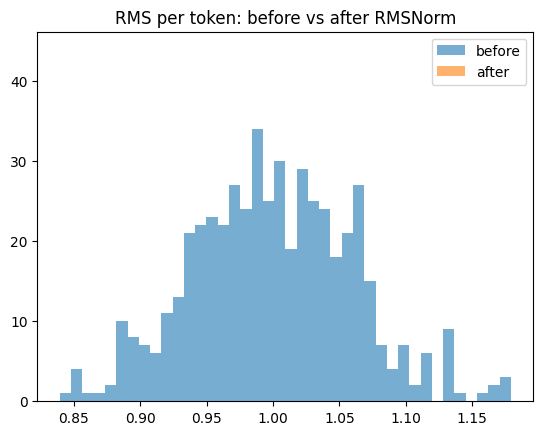

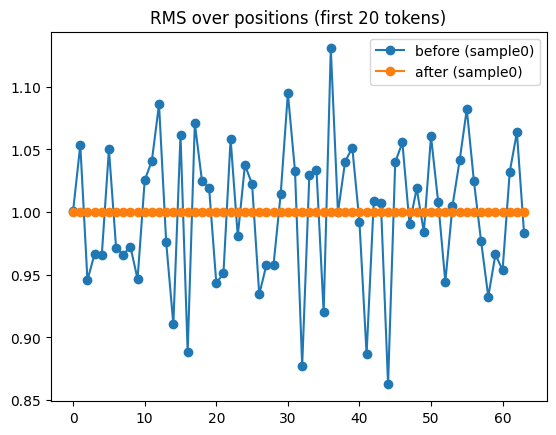

mean RMS before: 1.000349521636963 after: 0.9999948740005493


In [16]:
B, T, C = 8, 64, 129
x = torch.randn(B, T, C)

norm = RMSNorm(C)
y = norm(x)

rms_x = rms_per_token(x).flatten().detach().cpu().numpy()
rms_y = rms_per_token(y).flatten().detach().cpu().numpy()

plt.figure()
plt.hist(rms_x, bins=40, alpha=0.6, label="before")
plt.hist(rms_y, bins=40, alpha=0.6, label="after")
plt.title("RMS per token: before vs after RMSNorm")
plt.legend()
plt.show()

plt.figure()
plt.plot(rms_per_token(x)[0, :100].detach().cpu().numpy(), marker="o", label="before (sample0)")
plt.plot(rms_per_token(y)[0, :100].detach().cpu().numpy(), marker="o", label="after (sample0)")
plt.title("RMS over positions (first 20 tokens)")
plt.legend()
plt.show()

print("mean RMS before:", float(rms_x.mean()), "after:", float(rms_y.mean()))

---

## 2) RoPE / YaRN：`precompute_freqs_cis`

RoPE 为每个维度对（2D）准备旋转角：
- `freqs`：每个维度对的角频率（越“高频”变化越快）
- `angles[t, i] = t * freqs[i]`
- 最终拼出 `cos/sin`：形状 `[end, dim]`

YaRN 的直觉：
- 高频维度：尽量保持（不怎么缩放）
- 低频维度：缩放更大（让旋转更慢，更适合长位置）
- 中间：线性 ramp 过渡

In [4]:
def precompute_freqs_cis(dim: int, end: int = int(32 * 1024), rope_base: float = 1e6,
                         rope_scaling: Optional[dict] = None):
    # 1. 计算基础频率 theta_i = base^(-2i/d)
    freqs, attn_factor = 1.0 / (rope_base ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim)), 1.0
    
    # 2. YaRN 逻辑：如果需要处理比训练长度更长的序列
    if rope_scaling is not None:
        orig_max, factor, beta_fast, beta_slow, attn_factor = (
            rope_scaling.get("original_max_position_embeddings", 2048), 
            rope_scaling.get("factor", 16),
            rope_scaling.get("beta_fast", 32.0), 
            rope_scaling.get("beta_slow", 1.0), 
            rope_scaling.get("attention_factor", 1.0)
        )
        
        # 如果当前生成的长度 end 超过了原始训练长度 orig_max
        if end / orig_max > 1.0:
            # 计算波长，判断每个维度属于高频(High)还是低频(Low)
            inv_dim = lambda b: (dim * math.log(orig_max / (b * 2 * math.pi))) / (2 * math.log(rope_base))
            low, high = max(math.floor(inv_dim(beta_fast)), 0), min(math.ceil(inv_dim(beta_slow)), dim // 2 - 1)
            
            # Ramp 函数：0 代表高频（不插值），1 代表低频（插值），中间线性过渡
            ramp = torch.clamp((torch.arange(dim // 2, device=freqs.device).float() - low) / max(high - low, 0.001), 0, 1)
            
            # 修正频率：低频部分被“拉伸” (除以 factor)
            freqs = freqs * (1 - ramp + ramp / factor)

    # 3. 生成位置索引 t: [0, 1, ..., end]
    t = torch.arange(end, device=freqs.device)
    
    # 4. 外积计算 m * theta: [SeqLen, Dim/2]
    freqs = torch.outer(t, freqs).float()
    
    # 5. 拼接 cos/sin 得到 [SeqLen, Dim]
    # 注意这里 concat 了两次，是为了配合后面 rotate_half 的计算方式
    freqs_cos = torch.cat([torch.cos(freqs), torch.cos(freqs)], dim=-1) * attn_factor
    freqs_sin = torch.cat([torch.sin(freqs), torch.sin(freqs)], dim=-1) * attn_factor
    return freqs_cos, freqs_sin

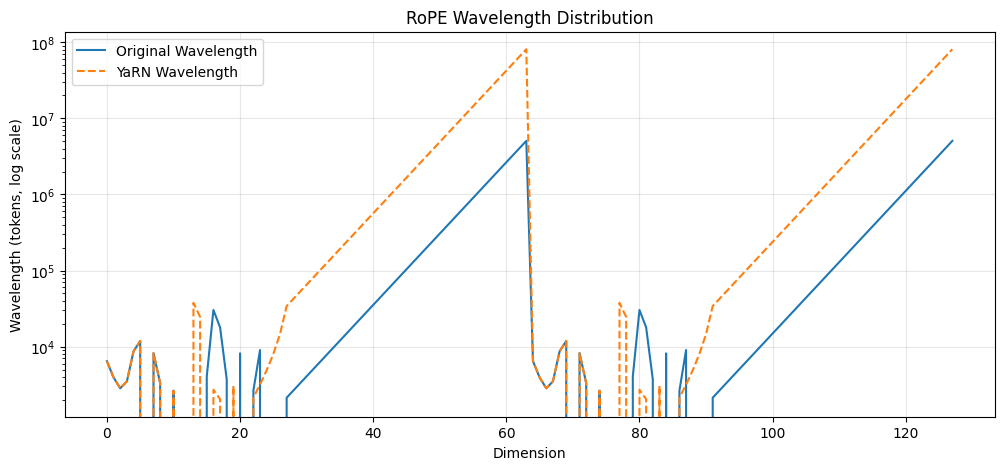

In [5]:
head_dim = 128
seq_len = 4096

# 情况 1: 普通 RoPE (无 Scaling)
cos_orig, sin_orig = precompute_freqs_cis(head_dim, end=seq_len)

# 情况 2: 开启 YaRN Scaling (假设我们要扩展 16倍长度)
rope_scaling = {
    "original_max_position_embeddings": 2048, # 原始只训练了 2048
    "factor": 16.0,
    "type": "yarn"
}
cos_yarn, sin_yarn = precompute_freqs_cis(head_dim, end=seq_len, rope_scaling=rope_scaling)

# 可视化对比：查看第 1000 个位置的频率分布
pos_idx = 1000

freqs_orig = torch.atan2(sin_orig[pos_idx], cos_orig[pos_idx]) / pos_idx
freqs_yarn = torch.atan2(sin_yarn[pos_idx], cos_yarn[pos_idx]) / pos_idx
lambda_orig = 2 * math.pi / freqs_orig
lambda_yarn = 2 * math.pi / freqs_yarn

plt.figure(figsize=(12, 5))
plt.plot(lambda_orig.numpy(), label="Original Wavelength")
plt.plot(lambda_yarn.numpy(), label="YaRN Wavelength", linestyle="--")
plt.yscale("log")
plt.xlabel("Dimension")
plt.ylabel("Wavelength (tokens, log scale)")
plt.title("RoPE Wavelength Distribution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# 高频不变 中间过渡 低频拉长

---

## 3) `apply_rotary_pos_emb`：对 Q/K 做旋转


In [2]:
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    # 辅助函数：将向量切半并交换，用于模拟复数乘法中的 i * (x + iy) 部分
    # [x1, x2] -> [-x2, x1]
    def rotate_half(x):
        return torch.cat((-x[..., x.shape[-1] // 2:], x[..., : x.shape[-1] // 2]), dim=-1)

    # 核心旋转公式：
    # q_embed = q * cos + rotate(q) * sin
    # 对应数学：(（x，y） * cos) + ((-y, x) * sin) = (x cos - y sin, x sin + y cos)
    
    # unsqueeze_dim=1 是为了处理广播：
    # q: [Batch, Seq, Heads, Dim]
    # cos: [Seq, Dim] -> [Seq, 1, Dim] -> 广播到 [Batch, Seq, Heads, Dim]
    q_embed = (q * cos.unsqueeze(unsqueeze_dim)) + (rotate_half(q) * sin.unsqueeze(unsqueeze_dim))
    k_embed = (k * cos.unsqueeze(unsqueeze_dim)) + (rotate_half(k) * sin.unsqueeze(unsqueeze_dim))
    return q_embed, k_embed


In [11]:
# 构造模拟数据
batch_size, seq_len, n_heads, head_dim = 2, 10, 4, 128

# 随机生成的 Q 和 K
q = torch.randn(batch_size, seq_len, n_heads, head_dim)
k = torch.randn(batch_size, seq_len, n_heads, head_dim)

# 获取位置编码 (前面计算好的 cos_orig)
# 注意：precompute 返回的是 [seq_len, head_dim]
# 我们只取需要的长度
cos = cos_orig[:seq_len, :]
sin = sin_orig[:seq_len, :]


# 应用旋转
q_rot, k_rot = apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=1)

print(f"原始 Q 形状: {q.shape}")
print(f"旋转后 Q 形状: {q_rot.shape} (保持不变)")

# 验证旋转效果：
# 理论上，RoPE 使得点积 q @ k.T 只取决于相对距离 (m-n)
# 这里仅作数值展示，证明数值确实发生了改变
print(f"\n原始向量前4位: {q[0, 1, 0, :8].tolist()}")
print(f"旋转向量前4位: {q_rot[0, 1, 0, :8].tolist()}")

原始 Q 形状: torch.Size([2, 10, 4, 128])
旋转后 Q 形状: torch.Size([2, 10, 4, 128]) (保持不变)

原始向量前4位: [-0.948097288608551, -1.5841405391693115, 0.6469853520393372, 0.5119714736938477, -0.18721747398376465, 0.2418137639760971, 1.0985703468322754, 0.22200413048267365]
旋转向量前4位: [-0.5177260637283325, -0.07589685916900635, 0.3253786563873291, 0.024921685457229614, -0.1120930016040802, 0.419443815946579, 0.4877311587333679, -0.03258773684501648]


## KV Cache 重复 (repeat_kv)

In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, num_key_value_heads, head_dim = x.shape
    
    if n_rep == 1: # MHA的时候，重复次数为1
        return x
    return (
        x[:, :, :, None, :].expand(bs, slen, num_key_value_heads, n_rep, head_dim).reshape(bs, slen, num_key_value_heads * n_rep, head_dim) # 否则扩展 第三个纬度 ，达到和q相同的shape，不过这里好像并不真实的占用内存
    )

In [13]:
# 模拟 GQA 场景
bs, seq, kv_heads, head_dim = 1, 5, 2, 4
n_rep = 3 # 每个 KV head 复制 3 次

# 简单的 KV tensor
# Head 0 全是 1, Head 1 全是 2
x_kv = torch.zeros(bs, seq, kv_heads, head_dim)
x_kv[:, :, 0, :] = 1.0 
x_kv[:, :, 1, :] = 2.0

print(f"原始 KV 形状: {x_kv.shape}") # [1, 5, 2, 4]

# 执行复制
x_kv_expanded = repeat_kv(x_kv, n_rep)

print(f"扩展后 KV 形状: {x_kv_expanded.shape}") # [1, 5, 6, 4] (2 * 3 = 6 heads)

# 验证数据：应该看到 1, 1, 1, 2, 2, 2 的模式
print("\n扩展后的 Heads 数据预览 (Head 0-5):")
for h in range(x_kv_expanded.shape[2]):
    print(f"Head {h}: {x_kv_expanded[0, 0, h, 0].item()}")

原始 KV 形状: torch.Size([1, 5, 2, 4])
扩展后 KV 形状: torch.Size([1, 5, 6, 4])

扩展后的 Heads 数据预览 (Head 0-5):
Head 0: 1.0
Head 1: 1.0
Head 2: 1.0
Head 3: 2.0
Head 4: 2.0
Head 5: 2.0
